The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Then we import the covid19_inference module.

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for Sweden.

In [6]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()

# extract confirmed data
bd = datetime.datetime(2020,3,3) # when cases began to increase quickly
ed = datetime.date.today() - datetime.timedelta(days=1) # yesterday
data_retrieval = datetime.datetime.now().strftime(format="%d/%m/%Y %H:%M")
print("Date and time of data retrieval: " + data_retrieval)
total_cases = jhu.get_confirmed(country = "Sweden", begin_date= bd, end_date = ed )

Date and time of data retrieval: 15/05/2020 10:56


In [7]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[ 14  59   7  60  42  45 107 145  99 215 147  61  81  87  89 160 200 124
 171 112 240 240 314 229 378 253 328 407 512 621 563 312 387 376 487 726
 722 544 466 332 465 497 482 613 676 606 563 392 545 682 751 812 610 463
 286 695 681 790 428 562 235 404 495 702 705 642 656 401 348 602 637 673]


For the choice of changing points, see https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Sweden

- 10/03 quarantine recommandations
- 17/03 school closure / home office recommandations
- 24/03 restrictions on restaurants etc.
- 01/04 nursing home visit ban
- 11/04 before easter
- 13/04 after easter

All the parameters chosen in the following amount to a quick, naive application of the model to Sweden. Delays are set as for Germany.

In [9]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_1 = datetime.datetime(2020,3,10)
prior_date_2 =  datetime.datetime(2020,3,17)
prior_date_3 =  datetime.datetime(2020,3,24)
prior_date_4 =  datetime.datetime(2020,4,1)
prior_date_5 = datetime.datetime(2020,4,11)
prior_date_6 = datetime.datetime(2020,4,13)

change_points = [dict(pr_mean_date_transient = prior_date_1,
                      pr_sigma_date_transient = 6, 
                      pr_median_lambda = 0.35,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_2,
                      pr_sigma_date_transient = 6, 
                      pr_median_lambda = 0.3,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_3,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.25,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_4,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_5,
                      pr_sigma_date_transient = 3, # reduced
                      pr_median_lambda = 0.25,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_6,
                      pr_sigma_date_transient = 3, # reduced
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1)]

New prior making implemented

In [10]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 10.2e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay, no weekend effect, pr_median_scale_delay as in the current
    # version of the one bundesland script
    new_cases_inferred = cov19.delay_cases(new_I_t, pr_median_delay=pr_median_delay, 
                                               pr_median_scale_delay=0.3,
                                               name_delayed_cases="new_cases")
    
    # name_delayed_cases="new_cases" is important because usually, the "new_cases" in the
    # trace come from weekend modulation and remain empty else.
    # delay as for Germany
    
    # NO weekend modulation!
    # new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len

In [11]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 539.42:  10%|▉         | 19099/200000 [02:17<21:41, 138.97it/s]
Convergence achieved at 19100
INFO     [pymc3.variational.inference] Convergence achieved at 19100
Interrupted at 19,099 [9%]: Average Loss = 608.02
INFO     [pymc3.variational.inference] Interrupted at 19,099 [9%]: Average Loss = 608.02
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay_log, I_begin_ratio_log, mu, transient_len_6_log, transient_len_5_log, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_6, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_6_log, lambda_5_log, lambda_4_log, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUT

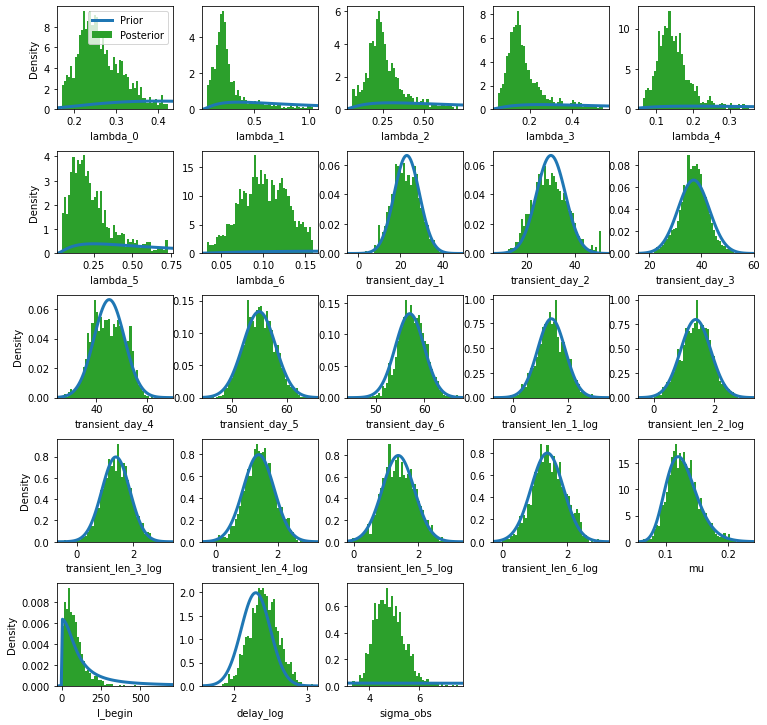

In [8]:
from importlib import reload
reload(cov19.plotting)
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'), lambda_exp=True,)
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

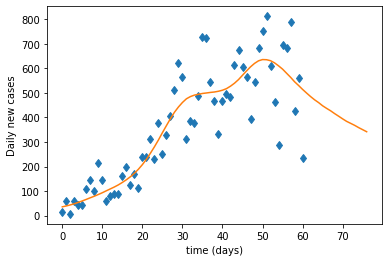

In [9]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

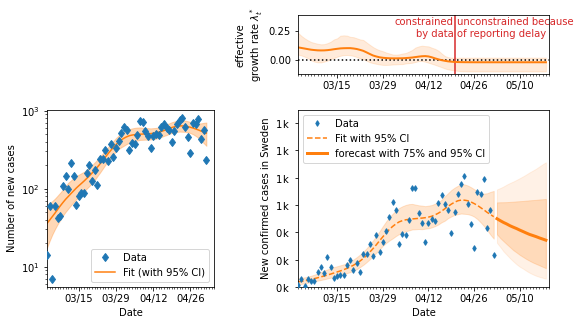

In [10]:
fig.subplots_adjust(wspace=0.25, hspace=0.4) 
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="Sweden", big=True)

In [ ]:
from covid19_inference import data_collection as cov19dc
lockdown_date = prior_date_3
lockdown_type = "restaurant closures"
other_vars = {"bd": bd, "ed": ed, 
              "diff_data_sim": diff_data_sim, "num_days_forecast": num_days_forecast, 
              "lockdown_date": lockdown_date, "lockdown_type": lockdown_type,
              "tune": 500, "draws": 500, "data_retrieval": data_retrieval}
cov19dc.update_collection("Sweden", "JHU", trace, model.unobserved_RVs, change_points, other_vars)